## Base Models

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from imblearn.over_sampling import SMOTE

In [44]:
pos_final_test = pd.read_csv('./data/pos_final_test.csv.gz', compression='gzip')
pos_final_test_KNN = pd.read_csv('./data/pos_KNN_final_test.csv.gz', compression='gzip')
pos_final_missing_data_test = pd.read_csv('./data/./pos_final_missing_data_test.csv.gz', compression='gzip')


In [45]:
pos_final_missing_data_test = pos_final_missing_data_test.fillna(-9999)

In [46]:
model_cols = ~pos_final_test.columns.isin(['(\'subject_id\', \'\')', '(\'hadm_id\', \'\')', 'subject_id', 'hadm_id', 'Unnamed: 0', 'pos'])
# model_cols = pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') | pos_final_test.columns.str.contains('above') | pos_final_test.columns.str.contains('abn') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])

hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

# hadm_features = pos_final_missing_data_test.loc[:, model_cols]
# hadm_target = pos_final_missing_data_test.loc[:, 'pos']


In [47]:
X_train, X_test, y_train, y_test = train_test_split(hadm_features, hadm_target, stratify=hadm_target, random_state=0)


In [115]:
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

Best parameter (CV score=0.810):
{'logistic__C': 0.00021544346900318845, 'pca__n_components': 20}


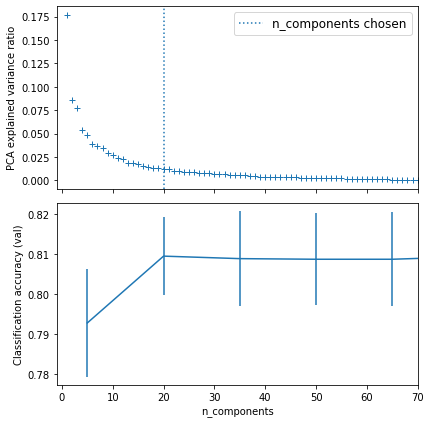

CPU times: user 3.5 s, sys: 299 ms, total: 3.8 s
Wall time: 6.42 s


In [121]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1, class_weight = "balanced")
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X_digits, y_digits = X_train, y_train
# X_digits, y_digits = X_res_over, y_res_over

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': range(5, 125, 15),
    'logistic__C': np.logspace(-6, 1, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

Accuracy Score: 80.51%
_______________________________________________
Classification Report:	Precision Score: 38.78%
			Recall Score: 68.23%
			F1 score: 49.45%
_______________________________________________
Confusion Matrix: 
 [[1519  322]
 [  95  204]]



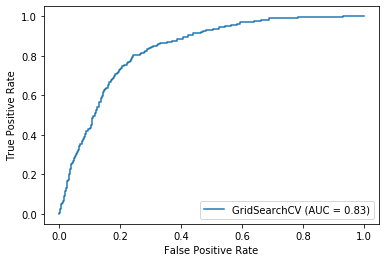

In [122]:
pred = search.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

svc_disp = plot_roc_curve(search, X_test, y_test)
plt.show()

In [123]:
# pd.DataFrame(pca.components_[:5],columns=X_train.columns)
pca_coef = pd.DataFrame(list(zip(pca.components_[0], X_train.columns)))
pca_coef.columns = ['coef', 'test']
pca_coef['coef'] = abs(pca_coef['coef'])
pca_coef.sort_values(by = 'coef', ascending = False).head(30)


,coef,test
9,0.205936,"('min', 'Hemoglobin - Blood - Hematology')"
77,0.201397,"('below_min', 'Hemoglobin - Blood - Hematology')"
83,0.198950,"('below_min', 'Red Blood Cells - Blood - Hemat..."
15,0.198910,"('min', 'Red Blood Cells - Blood - Hematology')"
8,0.198090,"('min', 'Hematocrit - Blood - Hematology')"
76,0.197078,"('below_min', 'Hematocrit - Blood - Hematology')"
43,0.196002,"('mean', 'Hemoglobin - Blood - Hematology')"
49,0.187099,"('mean', 'Red Blood Cells - Blood - Hematology')"
42,0.186015,"('mean', 'Hematocrit - Blood - Hematology')"
24,0.156070,"('max', 'Urea Nitrogen - Blood - Chemistry')"


## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time

# # L2
# params_log = [ {'C':np.logspace(-4, 3, 20)} ]
# logReg = LogisticRegression(max_iter = 2000, class_weight = "balanced")

# L1
params_log = [ {'C':np.logspace(-4, -1, 20)} ]
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear', scoring='roc_auc')

grid_log = GridSearchCV(estimator = logReg, param_grid = params_log, cv = 5)
grid_log.fit(X_train, y_train)
grid_log.best_score_

In [8]:
grid_log.best_params_

{'C': 0.00023357214690901214}

In [9]:
est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)

sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs > 0]

age                                        0.137544
('abn_percent', 51006)                     0.103972
('abn_percent', 51003)                     0.093135
('min', 51006)                             0.079919
('mean', 51006)                            0.076955
                                             ...   
('min', 50882)                             0.000205
('max', 50960)                             0.000187
('max', 51514)                             0.000136
('mean', 51478)                            0.000133
ethnicity_AMERICAN INDIAN/ALASKA NATIVE    0.000010
Length: 233, dtype: float64

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [11]:
pred = grid_log.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Accuracy Score: 80.78%
_______________________________________________
Classification Report:	Precision Score: 38.97%
			Recall Score: 70.67%
			F1 score: 50.24%
_______________________________________________
Confusion Matrix: 
 [[1553  332]
 [  88  212]]



## Random Forest

In [12]:
from sklearn import ensemble
import sklearn.model_selection as ms

randomForest = ensemble.RandomForestClassifier(class_weight = "balanced")

In [29]:
%%time

grid_para_forest = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'n_estimators': range(10, 110, 10)
}

grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_forest.fit(X_train, y_train)

CPU times: user 12.5 s, sys: 918 ms, total: 13.4 s
Wall time: 3min 48s


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'n_estimators': range(10, 110, 10)},
             scoring='accuracy')

In [30]:
# Get most important features
tree_final = grid_search_forest.best_estimator_
feature_importance = tree_final.feature_importances_
feature_importance = list(zip(X_train.columns, feature_importance))

feature_importance.sort(key = lambda x: x[1], reverse = True)
feature_importance

[("('mean', 51006)", 0.04041295519778409),
 ('age', 0.03575698966141188),
 ("('above_max', 51006)", 0.03554658660140722),
 ("('max', 51006)", 0.03446871494484349),
 ("('abn_percent', 51006)", 0.01820372397230878),
 ("('above_max', 50912)", 0.01792514762285037),
 ("('max', 51277)", 0.017696935805441436),
 ("('mean', 50912)", 0.01709015992300478),
 ("('max', 51274)", 0.01590825802658881),
 ("('max', 50912)", 0.014985362124171368),
 ("('min', 51006)", 0.014644040721538954),
 ("('abn_percent', 50912)", 0.01386933852007927),
 ("('mean', 51277)", 0.012523622191059444),
 ("('mean', 51003)", 0.012242601114197596),
 ("('mean', 51249)", 0.011993516795346467),
 ("('min', 51277)", 0.011912154526915214),
 ("('max', 51275)", 0.011709523592959853),
 ("('min', 51249)", 0.011468018705662221),
 ("('max', 50931)", 0.010637528990657424),
 ("('max', 51249)", 0.01063730127490966),
 ("('mean', 50971)", 0.010159004603389196),
 ("('mean', 51237)", 0.00997942436364579),
 ("('mean', 50902)", 0.009129142657071819

In [31]:
grid_search_forest.best_params_

{'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 70}

In [32]:
grid_search_forest.best_score_

0.8902790830378302

In [33]:
print("The training error is: %.5f" % (grid_search_forest.score(X_train, y_train)))
print("The test     error is: %.5f" % (grid_search_forest.score(X_test, y_test)))

The training error is: 0.99969
The test     error is: 0.87643


In [34]:
rf_predictions = tree_final.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, rf_predictions) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, rf_predictions) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, rf_predictions) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, rf_predictions) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, rf_predictions)}\n")

Accuracy Score: 87.64%
_______________________________________________
Classification Report:	Precision Score: 61.03%
			Recall Score: 27.67%
			F1 score: 38.07%
_______________________________________________
Confusion Matrix: 
 [[1832   53]
 [ 217   83]]

